In [1]:
%pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('../content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHKdRoIZh2vc10UT0vHZvA-TZwPFdphMRvnqFQYBDtmHy51N69x0S8
Mounted at ../content/drive


# 바꿔야할 부분
※ 경로

In [3]:
cd ../content/drive/My Drive/졸업작품/30words_classification

/content/drive/My Drive/졸업작품/30words_classification


In [4]:
''' import libraries '''

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms  # 1 batch = (1, 784)
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

In [5]:
# torch.device
print("is there cuda? :",  torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

is there cuda? : True
cuda:0


In [6]:
## data load
X_train, X_test, Y_train, Y_test = np.load("./data.npy", allow_pickle=True)

In [7]:
## data rehspae and normalize

Y_train = np.array([Y_train]) # (1, 27000, 30)
Y_train = np.transpose(Y_train, (1, 0, 2))  # (27000, 1, 30)
Y_test = np.array([Y_test]) # (1, 27000, 30)
Y_test = np.transpose(Y_test, (1, 0, 2))  # (27000, 1, 30)

X_train = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_train))
Y_train = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(Y_train))

X_test = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_test))
Y_test = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(Y_test))

print("X_train.shape", X_train.shape)  # (27000, 173, 24)
print("Y_train.shape", Y_train.shape)  # (27000, 1, 30)
print("X_test.shape", X_test.shape)  # (3000, 173, 24)
print("Y_test.shape", Y_test.shape)  # (1, 27000, 30)
# print("X_train[0]", X_train[0])  # 이미 되어있네? mean=0, std=1 로 되어있네


X_train.shape torch.Size([27000, 173, 24])
Y_train.shape torch.Size([27000, 1, 30])
X_test.shape torch.Size([3000, 173, 24])
Y_test.shape torch.Size([3000, 1, 30])


In [8]:
print(Y_train[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [8]:
n_mfcc = 24
Tx = 173
num_class = 30

In [18]:
## resnet 구현

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_class, p2=0.0): # 10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16) # conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(4)  # 8
        self.fc = nn.Linear(64*11, num_classes)

        self.dropout2d = nn.Dropout2d(p=p2)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.dropout2d(out)
        out = self.layer2(out)
        out = self.dropout2d(out)
        out = self.layer3(out)
        #out = self.dropout2d(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return nn.LogSoftmax(dim=-1)(out)

In [22]:
''' hyper parameters '''
# total_batch_num = int(len(train_data) / batch_size)
epochs = 25
lr = 0.001
# momentum = 0.9
print_interval = 100
#drop_prob1 = 0.1 # ->fc에서는 덜 줄이고
drop_prob2 = 0.1  # ->conv에서 
weight_decay = 1e-4

# # model, optimizer 초기화
model = ResNet(ResidualBlock, [2, 2, 2], p2=drop_prob2).to(device)  # [2, 2, 2] : blocks at each layer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [20]:
summary(model,input_size=(1, Tx, n_mfcc))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 173, 24]             144
       BatchNorm2d-2          [-1, 16, 173, 24]              32
              ReLU-3          [-1, 16, 173, 24]               0
            Conv2d-4          [-1, 16, 173, 24]           2,304
       BatchNorm2d-5          [-1, 16, 173, 24]              32
              ReLU-6          [-1, 16, 173, 24]               0
            Conv2d-7          [-1, 16, 173, 24]           2,304
       BatchNorm2d-8          [-1, 16, 173, 24]              32
              ReLU-9          [-1, 16, 173, 24]               0
    ResidualBlock-10          [-1, 16, 173, 24]               0
           Conv2d-11          [-1, 16, 173, 24]           2,304
      BatchNorm2d-12          [-1, 16, 173, 24]              32
             ReLU-13          [-1, 16, 173, 24]               0
           Conv2d-14          [-1, 16, 

In [212]:
# # 모델의 state_dict 출력
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
#     # model.state_dict()[param_tensor].dat => 접근가능하네!
# # 옵티마이저의 state_dict 출력
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

conv_layer1.0.weight 	 torch.Size([32, 1, 11, 3])
conv_layer1.0.bias 	 torch.Size([32])
conv_layer2.0.weight 	 torch.Size([64, 32, 3, 3])
conv_layer2.0.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 4992])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([30, 128])
fc2.bias 	 torch.Size([30])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.001, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


In [38]:
pip install torchviz

     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=b67c6a993cb90248649632165aadb7cd8d52c2c2849f3bc20155f35fb56517fb
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


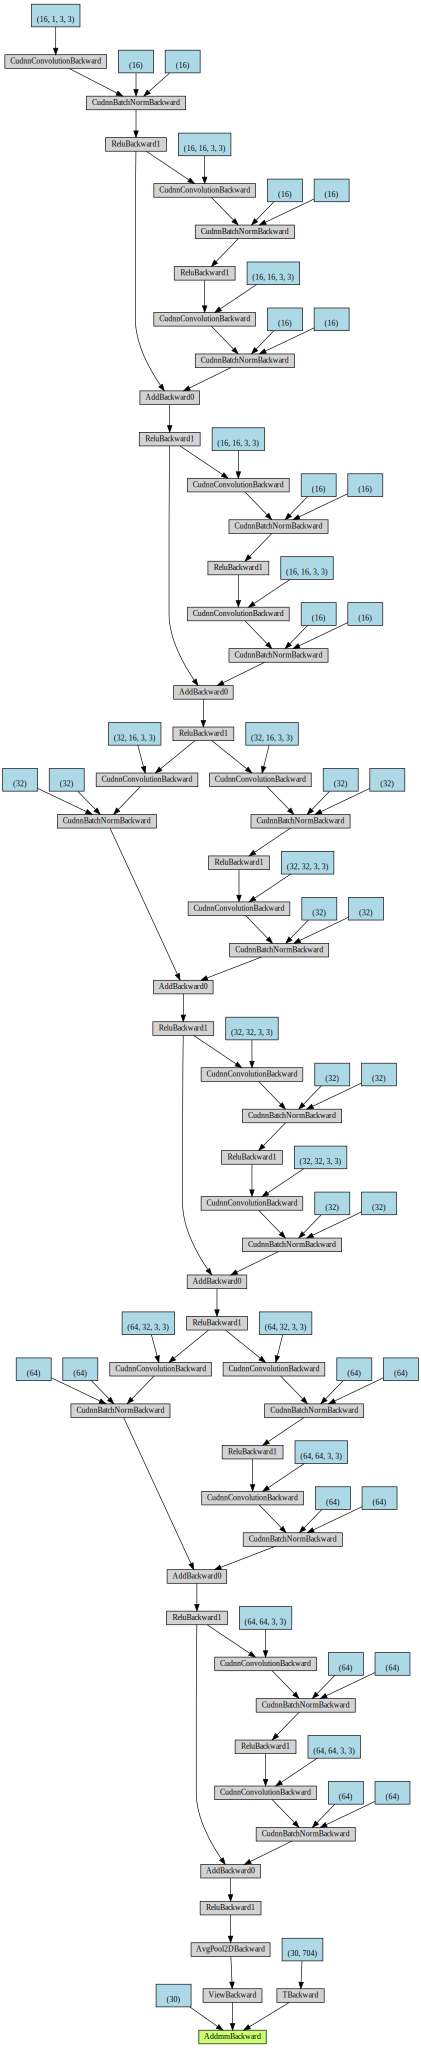

In [40]:
from torchviz import make_dot
x = torch.rand(1, 1, Tx, n_mfcc).to(device)
make_dot(model(x))

# 왜지?  
MNIST 코드에서,   
target.size = [batch_size]   
output.size = [batch_size, num_class]

F.nll_loss(output, target) -> 이 함수 요상하다

# 읽어볼 만한 것
https://wingnim.tistory.com/34

epoch: 0	batch Step: 0	Loss: 35.990	Accuracy: 0.000
epoch: 0	batch Step: 100	Loss: 34.643	Accuracy: 0.000
epoch: 0	batch Step: 200	Loss: 33.053	Accuracy: 0.000
epoch: 0	batch Step: 300	Loss: 30.677	Accuracy: 10.000
epoch: 0	batch Step: 400	Loss: 31.215	Accuracy: 0.000
epoch: 0	batch Step: 500	Loss: 27.831	Accuracy: 20.000
epoch: 0	batch Step: 600	Loss: 31.229	Accuracy: 10.000
epoch: 0	batch Step: 700	Loss: 16.439	Accuracy: 60.000
epoch: 0	batch Step: 800	Loss: 28.051	Accuracy: 20.000
epoch: 0	batch Step: 900	Loss: 20.471	Accuracy: 30.000
epoch: 0	batch Step: 1000	Loss: 23.283	Accuracy: 20.000
epoch: 0	batch Step: 1100	Loss: 15.879	Accuracy: 50.000
epoch: 0	batch Step: 1200	Loss: 20.409	Accuracy: 60.000
epoch: 0	batch Step: 1300	Loss: 14.106	Accuracy: 60.000
epoch: 0	batch Step: 1400	Loss: 21.413	Accuracy: 40.000
epoch: 0	batch Step: 1500	Loss: 24.626	Accuracy: 50.000
epoch: 0	batch Step: 1600	Loss: 18.594	Accuracy: 50.000
epoch: 0	batch Step: 1700	Loss: 20.364	Accuracy: 50.000
epoch: 0

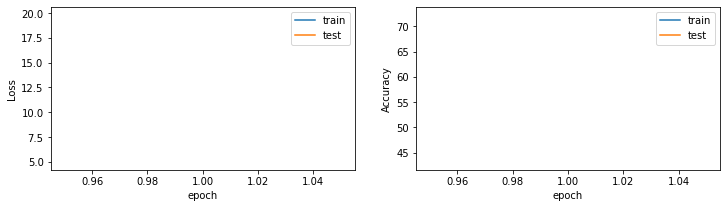

epoch: 1	batch Step: 0	Loss: 10.092	Accuracy: 70.000
epoch: 1	batch Step: 100	Loss: 17.037	Accuracy: 80.000
epoch: 1	batch Step: 200	Loss: 2.745	Accuracy: 100.000
epoch: 1	batch Step: 300	Loss: 5.846	Accuracy: 80.000
epoch: 1	batch Step: 400	Loss: 3.390	Accuracy: 100.000
epoch: 1	batch Step: 500	Loss: 3.739	Accuracy: 90.000
epoch: 1	batch Step: 600	Loss: 7.216	Accuracy: 80.000
epoch: 1	batch Step: 700	Loss: 4.546	Accuracy: 90.000
epoch: 1	batch Step: 800	Loss: 6.253	Accuracy: 80.000
epoch: 1	batch Step: 900	Loss: 10.159	Accuracy: 80.000
epoch: 1	batch Step: 1000	Loss: 11.128	Accuracy: 60.000
epoch: 1	batch Step: 1100	Loss: 6.223	Accuracy: 70.000
epoch: 1	batch Step: 1200	Loss: 6.448	Accuracy: 70.000
epoch: 1	batch Step: 1300	Loss: 7.948	Accuracy: 70.000
epoch: 1	batch Step: 1400	Loss: 9.562	Accuracy: 80.000
epoch: 1	batch Step: 1500	Loss: 7.809	Accuracy: 90.000
epoch: 1	batch Step: 1600	Loss: 6.544	Accuracy: 80.000
epoch: 1	batch Step: 1700	Loss: 6.355	Accuracy: 90.000
epoch: 1	batch S

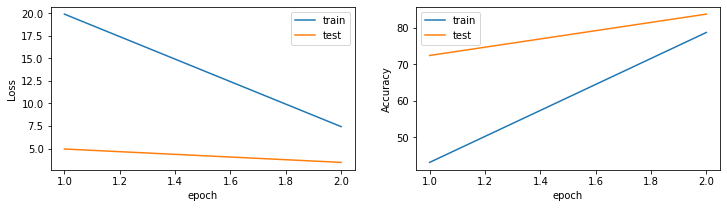

epoch: 2	batch Step: 0	Loss: 11.295	Accuracy: 60.000
epoch: 2	batch Step: 100	Loss: 8.691	Accuracy: 80.000
epoch: 2	batch Step: 200	Loss: 0.860	Accuracy: 100.000
epoch: 2	batch Step: 300	Loss: 1.182	Accuracy: 100.000
epoch: 2	batch Step: 400	Loss: 0.769	Accuracy: 100.000
epoch: 2	batch Step: 500	Loss: 1.225	Accuracy: 100.000
epoch: 2	batch Step: 600	Loss: 6.867	Accuracy: 80.000
epoch: 2	batch Step: 700	Loss: 1.265	Accuracy: 100.000
epoch: 2	batch Step: 800	Loss: 1.841	Accuracy: 100.000
epoch: 2	batch Step: 900	Loss: 4.971	Accuracy: 80.000
epoch: 2	batch Step: 1000	Loss: 5.251	Accuracy: 90.000
epoch: 2	batch Step: 1100	Loss: 3.246	Accuracy: 90.000
epoch: 2	batch Step: 1200	Loss: 5.157	Accuracy: 80.000
epoch: 2	batch Step: 1300	Loss: 3.706	Accuracy: 80.000
epoch: 2	batch Step: 1400	Loss: 7.641	Accuracy: 70.000
epoch: 2	batch Step: 1500	Loss: 3.734	Accuracy: 80.000
epoch: 2	batch Step: 1600	Loss: 2.898	Accuracy: 90.000
epoch: 2	batch Step: 1700	Loss: 3.633	Accuracy: 90.000
epoch: 2	batch 

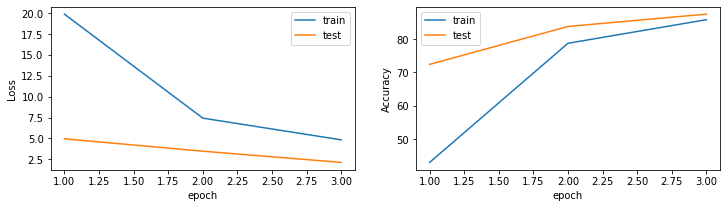

epoch: 3	batch Step: 0	Loss: 8.771	Accuracy: 70.000
epoch: 3	batch Step: 100	Loss: 7.468	Accuracy: 90.000
epoch: 3	batch Step: 200	Loss: 0.209	Accuracy: 100.000
epoch: 3	batch Step: 300	Loss: 1.031	Accuracy: 100.000
epoch: 3	batch Step: 400	Loss: 0.160	Accuracy: 100.000
epoch: 3	batch Step: 500	Loss: 2.195	Accuracy: 90.000
epoch: 3	batch Step: 600	Loss: 4.960	Accuracy: 70.000
epoch: 3	batch Step: 700	Loss: 0.206	Accuracy: 100.000
epoch: 3	batch Step: 800	Loss: 0.923	Accuracy: 100.000
epoch: 3	batch Step: 900	Loss: 3.992	Accuracy: 90.000
epoch: 3	batch Step: 1000	Loss: 4.234	Accuracy: 90.000
epoch: 3	batch Step: 1100	Loss: 3.587	Accuracy: 80.000
epoch: 3	batch Step: 1200	Loss: 10.099	Accuracy: 80.000
epoch: 3	batch Step: 1300	Loss: 1.884	Accuracy: 90.000
epoch: 3	batch Step: 1400	Loss: 6.305	Accuracy: 80.000
epoch: 3	batch Step: 1500	Loss: 2.698	Accuracy: 90.000
epoch: 3	batch Step: 1600	Loss: 2.448	Accuracy: 100.000
epoch: 3	batch Step: 1700	Loss: 2.607	Accuracy: 90.000
epoch: 3	batch 

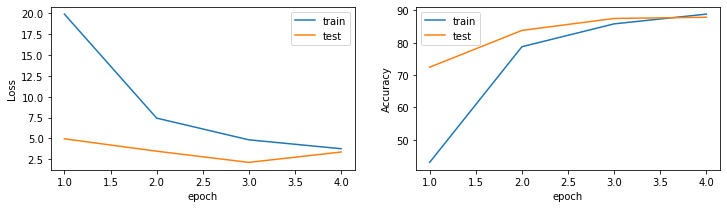

epoch: 4	batch Step: 0	Loss: 8.453	Accuracy: 80.000
epoch: 4	batch Step: 100	Loss: 6.990	Accuracy: 80.000
epoch: 4	batch Step: 200	Loss: 0.128	Accuracy: 100.000
epoch: 4	batch Step: 300	Loss: 0.344	Accuracy: 100.000
epoch: 4	batch Step: 400	Loss: 0.179	Accuracy: 100.000
epoch: 4	batch Step: 500	Loss: 0.801	Accuracy: 100.000
epoch: 4	batch Step: 600	Loss: 6.224	Accuracy: 70.000
epoch: 4	batch Step: 700	Loss: 0.133	Accuracy: 100.000
epoch: 4	batch Step: 800	Loss: 0.136	Accuracy: 100.000
epoch: 4	batch Step: 900	Loss: 2.372	Accuracy: 90.000
epoch: 4	batch Step: 1000	Loss: 4.478	Accuracy: 90.000
epoch: 4	batch Step: 1100	Loss: 2.572	Accuracy: 90.000
epoch: 4	batch Step: 1200	Loss: 5.063	Accuracy: 90.000
epoch: 4	batch Step: 1300	Loss: 1.021	Accuracy: 100.000
epoch: 4	batch Step: 1400	Loss: 6.763	Accuracy: 80.000
epoch: 4	batch Step: 1500	Loss: 0.671	Accuracy: 100.000
epoch: 4	batch Step: 1600	Loss: 3.357	Accuracy: 90.000
epoch: 4	batch Step: 1700	Loss: 2.643	Accuracy: 80.000
epoch: 4	batch

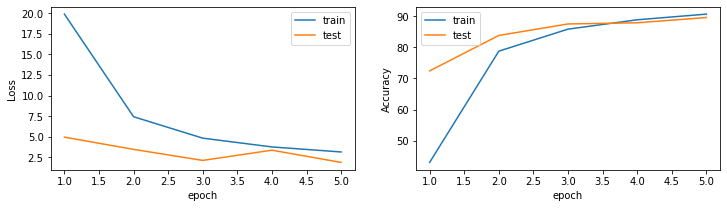

epoch: 5	batch Step: 0	Loss: 4.023	Accuracy: 70.000
epoch: 5	batch Step: 100	Loss: 5.298	Accuracy: 90.000
epoch: 5	batch Step: 200	Loss: 0.132	Accuracy: 100.000
epoch: 5	batch Step: 300	Loss: 1.851	Accuracy: 90.000
epoch: 5	batch Step: 400	Loss: 0.054	Accuracy: 100.000
epoch: 5	batch Step: 500	Loss: 2.062	Accuracy: 90.000
epoch: 5	batch Step: 600	Loss: 3.456	Accuracy: 80.000
epoch: 5	batch Step: 700	Loss: 0.129	Accuracy: 100.000
epoch: 5	batch Step: 800	Loss: 0.998	Accuracy: 90.000
epoch: 5	batch Step: 900	Loss: 1.942	Accuracy: 90.000
epoch: 5	batch Step: 1000	Loss: 1.971	Accuracy: 90.000
epoch: 5	batch Step: 1100	Loss: 1.840	Accuracy: 90.000
epoch: 5	batch Step: 1200	Loss: 3.501	Accuracy: 90.000
epoch: 5	batch Step: 1300	Loss: 1.906	Accuracy: 90.000
epoch: 5	batch Step: 1400	Loss: 7.269	Accuracy: 80.000
epoch: 5	batch Step: 1500	Loss: 1.120	Accuracy: 100.000
epoch: 5	batch Step: 1600	Loss: 1.345	Accuracy: 100.000
epoch: 5	batch Step: 1700	Loss: 2.370	Accuracy: 90.000
epoch: 5	batch St

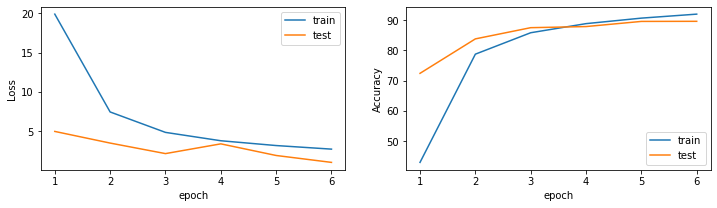

epoch: 6	batch Step: 0	Loss: 5.964	Accuracy: 80.000
epoch: 6	batch Step: 100	Loss: 2.673	Accuracy: 90.000
epoch: 6	batch Step: 200	Loss: 0.042	Accuracy: 100.000
epoch: 6	batch Step: 300	Loss: 0.309	Accuracy: 100.000
epoch: 6	batch Step: 400	Loss: 0.041	Accuracy: 100.000
epoch: 6	batch Step: 500	Loss: 1.600	Accuracy: 90.000
epoch: 6	batch Step: 600	Loss: 1.162	Accuracy: 100.000
epoch: 6	batch Step: 700	Loss: 0.073	Accuracy: 100.000
epoch: 6	batch Step: 800	Loss: 0.290	Accuracy: 100.000
epoch: 6	batch Step: 900	Loss: 1.215	Accuracy: 100.000
epoch: 6	batch Step: 1000	Loss: 3.054	Accuracy: 90.000
epoch: 6	batch Step: 1100	Loss: 0.749	Accuracy: 100.000
epoch: 6	batch Step: 1200	Loss: 1.401	Accuracy: 100.000
epoch: 6	batch Step: 1300	Loss: 2.337	Accuracy: 90.000
epoch: 6	batch Step: 1400	Loss: 3.627	Accuracy: 90.000
epoch: 6	batch Step: 1500	Loss: 2.185	Accuracy: 90.000
epoch: 6	batch Step: 1600	Loss: 2.707	Accuracy: 90.000
epoch: 6	batch Step: 1700	Loss: 1.135	Accuracy: 100.000
epoch: 6	bat

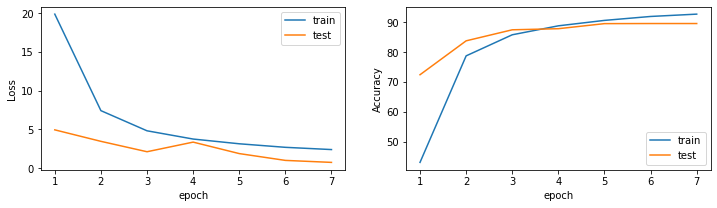

epoch: 7	batch Step: 0	Loss: 1.613	Accuracy: 90.000
epoch: 7	batch Step: 100	Loss: 4.218	Accuracy: 90.000
epoch: 7	batch Step: 200	Loss: 0.084	Accuracy: 100.000
epoch: 7	batch Step: 300	Loss: 0.770	Accuracy: 100.000
epoch: 7	batch Step: 400	Loss: 0.055	Accuracy: 100.000
epoch: 7	batch Step: 500	Loss: 0.226	Accuracy: 100.000
epoch: 7	batch Step: 600	Loss: 1.070	Accuracy: 100.000
epoch: 7	batch Step: 700	Loss: 0.035	Accuracy: 100.000
epoch: 7	batch Step: 800	Loss: 0.048	Accuracy: 100.000
epoch: 7	batch Step: 900	Loss: 2.193	Accuracy: 90.000
epoch: 7	batch Step: 1000	Loss: 1.579	Accuracy: 90.000
epoch: 7	batch Step: 1100	Loss: 1.107	Accuracy: 100.000
epoch: 7	batch Step: 1200	Loss: 2.931	Accuracy: 90.000
epoch: 7	batch Step: 1300	Loss: 1.920	Accuracy: 90.000
epoch: 7	batch Step: 1400	Loss: 2.327	Accuracy: 100.000
epoch: 7	batch Step: 1500	Loss: 0.338	Accuracy: 100.000
epoch: 7	batch Step: 1600	Loss: 1.629	Accuracy: 100.000
epoch: 7	batch Step: 1700	Loss: 0.331	Accuracy: 100.000
epoch: 7	b

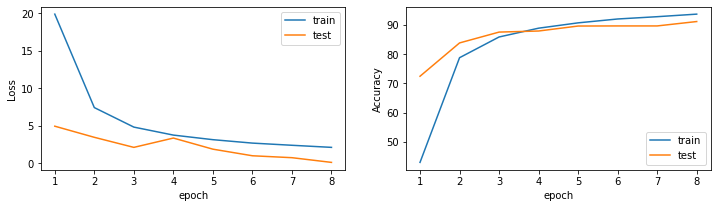

epoch: 8	batch Step: 0	Loss: 0.809	Accuracy: 100.000
epoch: 8	batch Step: 100	Loss: 2.126	Accuracy: 90.000
epoch: 8	batch Step: 200	Loss: 0.027	Accuracy: 100.000
epoch: 8	batch Step: 300	Loss: 0.624	Accuracy: 100.000
epoch: 8	batch Step: 400	Loss: 0.028	Accuracy: 100.000
epoch: 8	batch Step: 500	Loss: 0.216	Accuracy: 100.000
epoch: 8	batch Step: 600	Loss: 4.321	Accuracy: 80.000
epoch: 8	batch Step: 700	Loss: 0.010	Accuracy: 100.000
epoch: 8	batch Step: 800	Loss: 1.852	Accuracy: 90.000
epoch: 8	batch Step: 900	Loss: 0.576	Accuracy: 100.000
epoch: 8	batch Step: 1000	Loss: 1.796	Accuracy: 90.000
epoch: 8	batch Step: 1100	Loss: 0.998	Accuracy: 100.000
epoch: 8	batch Step: 1200	Loss: 3.374	Accuracy: 90.000
epoch: 8	batch Step: 1300	Loss: 1.528	Accuracy: 90.000
epoch: 8	batch Step: 1400	Loss: 2.768	Accuracy: 90.000
epoch: 8	batch Step: 1500	Loss: 1.216	Accuracy: 100.000
epoch: 8	batch Step: 1600	Loss: 1.419	Accuracy: 90.000
epoch: 8	batch Step: 1700	Loss: 0.614	Accuracy: 100.000
epoch: 8	bat

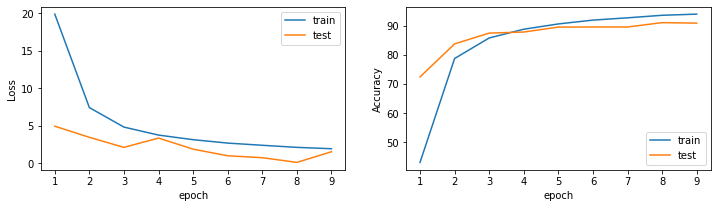

epoch: 9	batch Step: 0	Loss: 1.336	Accuracy: 100.000
epoch: 9	batch Step: 100	Loss: 0.687	Accuracy: 100.000
epoch: 9	batch Step: 200	Loss: 0.106	Accuracy: 100.000
epoch: 9	batch Step: 300	Loss: 6.358	Accuracy: 90.000
epoch: 9	batch Step: 400	Loss: 0.053	Accuracy: 100.000
epoch: 9	batch Step: 500	Loss: 0.333	Accuracy: 100.000
epoch: 9	batch Step: 600	Loss: 0.578	Accuracy: 100.000
epoch: 9	batch Step: 700	Loss: 0.012	Accuracy: 100.000
epoch: 9	batch Step: 800	Loss: 0.521	Accuracy: 100.000
epoch: 9	batch Step: 900	Loss: 0.484	Accuracy: 100.000
epoch: 9	batch Step: 1000	Loss: 1.923	Accuracy: 90.000
epoch: 9	batch Step: 1100	Loss: 1.718	Accuracy: 90.000
epoch: 9	batch Step: 1200	Loss: 2.119	Accuracy: 90.000
epoch: 9	batch Step: 1300	Loss: 0.661	Accuracy: 100.000
epoch: 9	batch Step: 1400	Loss: 3.803	Accuracy: 90.000
epoch: 9	batch Step: 1500	Loss: 0.919	Accuracy: 100.000
epoch: 9	batch Step: 1600	Loss: 1.863	Accuracy: 90.000
epoch: 9	batch Step: 1700	Loss: 0.788	Accuracy: 100.000
epoch: 9	b

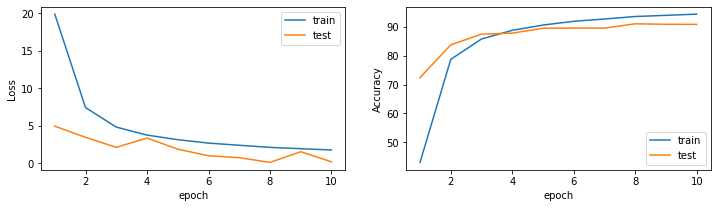

epoch: 10	batch Step: 0	Loss: 0.450	Accuracy: 100.000
epoch: 10	batch Step: 100	Loss: 1.657	Accuracy: 90.000
epoch: 10	batch Step: 200	Loss: 0.069	Accuracy: 100.000
epoch: 10	batch Step: 300	Loss: 0.709	Accuracy: 100.000
epoch: 10	batch Step: 400	Loss: 0.011	Accuracy: 100.000
epoch: 10	batch Step: 500	Loss: 1.544	Accuracy: 90.000
epoch: 10	batch Step: 600	Loss: 1.573	Accuracy: 90.000
epoch: 10	batch Step: 700	Loss: 0.018	Accuracy: 100.000
epoch: 10	batch Step: 800	Loss: 0.847	Accuracy: 100.000
epoch: 10	batch Step: 900	Loss: 1.041	Accuracy: 100.000
epoch: 10	batch Step: 1000	Loss: 1.385	Accuracy: 90.000
epoch: 10	batch Step: 1100	Loss: 0.630	Accuracy: 100.000
epoch: 10	batch Step: 1200	Loss: 1.200	Accuracy: 100.000
epoch: 10	batch Step: 1300	Loss: 0.784	Accuracy: 100.000
epoch: 10	batch Step: 1400	Loss: 2.090	Accuracy: 100.000
epoch: 10	batch Step: 1500	Loss: 0.085	Accuracy: 100.000
epoch: 10	batch Step: 1600	Loss: 1.470	Accuracy: 100.000
epoch: 10	batch Step: 1700	Loss: 0.406	Accuracy

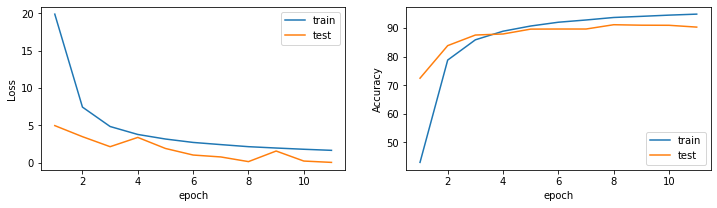

epoch: 11	batch Step: 0	Loss: 1.277	Accuracy: 100.000
epoch: 11	batch Step: 100	Loss: 4.588	Accuracy: 90.000
epoch: 11	batch Step: 200	Loss: 0.187	Accuracy: 100.000
epoch: 11	batch Step: 300	Loss: 2.282	Accuracy: 90.000
epoch: 11	batch Step: 400	Loss: 0.017	Accuracy: 100.000
epoch: 11	batch Step: 500	Loss: 0.048	Accuracy: 100.000
epoch: 11	batch Step: 600	Loss: 0.679	Accuracy: 100.000
epoch: 11	batch Step: 700	Loss: 0.015	Accuracy: 100.000
epoch: 11	batch Step: 800	Loss: 1.508	Accuracy: 90.000
epoch: 11	batch Step: 900	Loss: 0.268	Accuracy: 100.000
epoch: 11	batch Step: 1000	Loss: 0.927	Accuracy: 100.000
epoch: 11	batch Step: 1100	Loss: 1.647	Accuracy: 90.000
epoch: 11	batch Step: 1200	Loss: 1.802	Accuracy: 100.000
epoch: 11	batch Step: 1300	Loss: 0.445	Accuracy: 100.000
epoch: 11	batch Step: 1400	Loss: 1.230	Accuracy: 90.000
epoch: 11	batch Step: 1500	Loss: 2.002	Accuracy: 100.000
epoch: 11	batch Step: 1600	Loss: 2.796	Accuracy: 90.000
epoch: 11	batch Step: 1700	Loss: 3.086	Accuracy: 

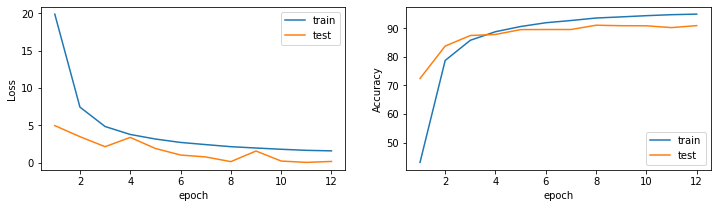

epoch: 12	batch Step: 0	Loss: 1.262	Accuracy: 100.000
epoch: 12	batch Step: 100	Loss: 1.490	Accuracy: 90.000
epoch: 12	batch Step: 200	Loss: 0.015	Accuracy: 100.000
epoch: 12	batch Step: 300	Loss: 1.431	Accuracy: 100.000
epoch: 12	batch Step: 400	Loss: 0.004	Accuracy: 100.000
epoch: 12	batch Step: 500	Loss: 0.407	Accuracy: 100.000
epoch: 12	batch Step: 600	Loss: 2.547	Accuracy: 90.000
epoch: 12	batch Step: 700	Loss: 0.111	Accuracy: 100.000
epoch: 12	batch Step: 800	Loss: 0.257	Accuracy: 100.000
epoch: 12	batch Step: 900	Loss: 0.586	Accuracy: 100.000
epoch: 12	batch Step: 1000	Loss: 3.352	Accuracy: 90.000
epoch: 12	batch Step: 1100	Loss: 0.508	Accuracy: 100.000
epoch: 12	batch Step: 1200	Loss: 5.537	Accuracy: 70.000
epoch: 12	batch Step: 1300	Loss: 0.102	Accuracy: 100.000
epoch: 12	batch Step: 1400	Loss: 1.693	Accuracy: 90.000
epoch: 12	batch Step: 1500	Loss: 0.215	Accuracy: 100.000
epoch: 12	batch Step: 1600	Loss: 1.990	Accuracy: 100.000
epoch: 12	batch Step: 1700	Loss: 1.409	Accuracy:

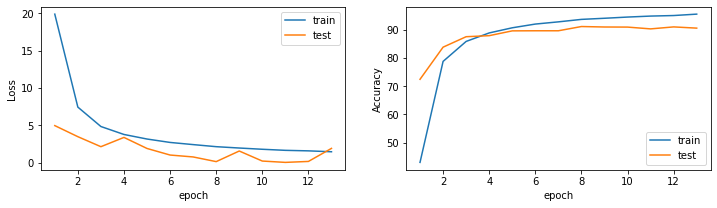

epoch: 13	batch Step: 0	Loss: 1.433	Accuracy: 90.000
epoch: 13	batch Step: 100	Loss: 3.754	Accuracy: 90.000
epoch: 13	batch Step: 200	Loss: 0.192	Accuracy: 100.000
epoch: 13	batch Step: 300	Loss: 0.724	Accuracy: 100.000
epoch: 13	batch Step: 400	Loss: 0.006	Accuracy: 100.000
epoch: 13	batch Step: 500	Loss: 0.909	Accuracy: 90.000
epoch: 13	batch Step: 600	Loss: 1.959	Accuracy: 90.000
epoch: 13	batch Step: 700	Loss: 0.002	Accuracy: 100.000
epoch: 13	batch Step: 800	Loss: 0.252	Accuracy: 100.000
epoch: 13	batch Step: 900	Loss: 0.594	Accuracy: 100.000
epoch: 13	batch Step: 1000	Loss: 3.397	Accuracy: 90.000
epoch: 13	batch Step: 1100	Loss: 0.718	Accuracy: 100.000
epoch: 13	batch Step: 1200	Loss: 1.398	Accuracy: 100.000
epoch: 13	batch Step: 1300	Loss: 0.097	Accuracy: 100.000
epoch: 13	batch Step: 1400	Loss: 0.202	Accuracy: 100.000
epoch: 13	batch Step: 1500	Loss: 1.425	Accuracy: 100.000
epoch: 13	batch Step: 1600	Loss: 0.727	Accuracy: 100.000
epoch: 13	batch Step: 1700	Loss: 2.033	Accuracy:

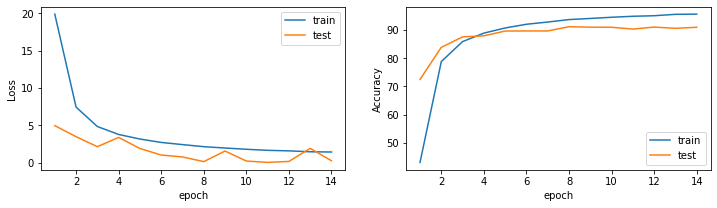

epoch: 14	batch Step: 0	Loss: 0.929	Accuracy: 100.000
epoch: 14	batch Step: 100	Loss: 0.485	Accuracy: 100.000
epoch: 14	batch Step: 200	Loss: 0.029	Accuracy: 100.000
epoch: 14	batch Step: 300	Loss: 0.070	Accuracy: 100.000
epoch: 14	batch Step: 400	Loss: 0.008	Accuracy: 100.000
epoch: 14	batch Step: 500	Loss: 0.235	Accuracy: 100.000
epoch: 14	batch Step: 600	Loss: 0.220	Accuracy: 100.000
epoch: 14	batch Step: 700	Loss: 0.173	Accuracy: 100.000
epoch: 14	batch Step: 800	Loss: 0.525	Accuracy: 100.000
epoch: 14	batch Step: 900	Loss: 1.971	Accuracy: 90.000
epoch: 14	batch Step: 1000	Loss: 3.689	Accuracy: 90.000
epoch: 14	batch Step: 1100	Loss: 0.161	Accuracy: 100.000
epoch: 14	batch Step: 1200	Loss: 5.102	Accuracy: 80.000
epoch: 14	batch Step: 1300	Loss: 0.093	Accuracy: 100.000
epoch: 14	batch Step: 1400	Loss: 0.702	Accuracy: 100.000
epoch: 14	batch Step: 1500	Loss: 0.505	Accuracy: 100.000
epoch: 14	batch Step: 1600	Loss: 0.553	Accuracy: 100.000
epoch: 14	batch Step: 1700	Loss: 1.604	Accurac

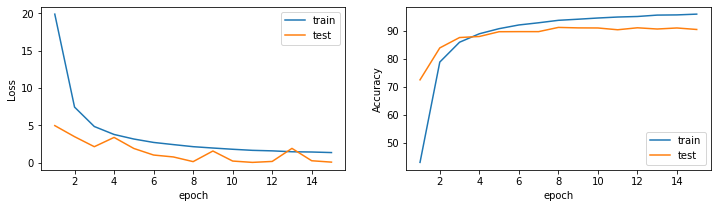

epoch: 15	batch Step: 0	Loss: 0.617	Accuracy: 100.000
epoch: 15	batch Step: 100	Loss: 3.229	Accuracy: 90.000
epoch: 15	batch Step: 200	Loss: 0.006	Accuracy: 100.000
epoch: 15	batch Step: 300	Loss: 0.248	Accuracy: 100.000
epoch: 15	batch Step: 400	Loss: 0.019	Accuracy: 100.000
epoch: 15	batch Step: 500	Loss: 0.391	Accuracy: 100.000
epoch: 15	batch Step: 600	Loss: 1.397	Accuracy: 100.000
epoch: 15	batch Step: 700	Loss: 0.005	Accuracy: 100.000
epoch: 15	batch Step: 800	Loss: 0.309	Accuracy: 100.000
epoch: 15	batch Step: 900	Loss: 1.054	Accuracy: 90.000
epoch: 15	batch Step: 1000	Loss: 0.786	Accuracy: 100.000
epoch: 15	batch Step: 1100	Loss: 0.350	Accuracy: 100.000
epoch: 15	batch Step: 1200	Loss: 2.416	Accuracy: 90.000
epoch: 15	batch Step: 1300	Loss: 0.668	Accuracy: 100.000
epoch: 15	batch Step: 1400	Loss: 3.220	Accuracy: 80.000
epoch: 15	batch Step: 1500	Loss: 0.918	Accuracy: 100.000
epoch: 15	batch Step: 1600	Loss: 1.101	Accuracy: 100.000
epoch: 15	batch Step: 1700	Loss: 0.151	Accuracy

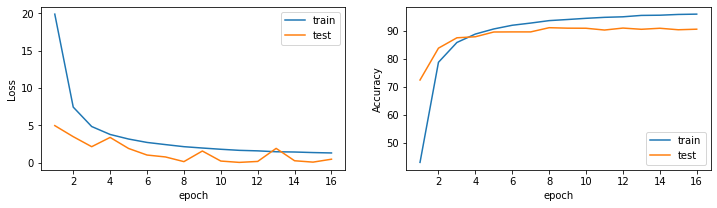

epoch: 16	batch Step: 0	Loss: 1.929	Accuracy: 90.000
epoch: 16	batch Step: 100	Loss: 6.946	Accuracy: 80.000
epoch: 16	batch Step: 200	Loss: 0.045	Accuracy: 100.000
epoch: 16	batch Step: 300	Loss: 0.048	Accuracy: 100.000
epoch: 16	batch Step: 400	Loss: 0.011	Accuracy: 100.000
epoch: 16	batch Step: 500	Loss: 0.254	Accuracy: 100.000
epoch: 16	batch Step: 600	Loss: 0.477	Accuracy: 100.000
epoch: 16	batch Step: 700	Loss: 0.028	Accuracy: 100.000
epoch: 16	batch Step: 800	Loss: 0.104	Accuracy: 100.000
epoch: 16	batch Step: 900	Loss: 0.286	Accuracy: 100.000
epoch: 16	batch Step: 1000	Loss: 1.094	Accuracy: 90.000
epoch: 16	batch Step: 1100	Loss: 0.232	Accuracy: 100.000
epoch: 16	batch Step: 1200	Loss: 0.768	Accuracy: 100.000
epoch: 16	batch Step: 1300	Loss: 0.107	Accuracy: 100.000
epoch: 16	batch Step: 1400	Loss: 3.233	Accuracy: 80.000
epoch: 16	batch Step: 1500	Loss: 0.083	Accuracy: 100.000
epoch: 16	batch Step: 1600	Loss: 1.093	Accuracy: 100.000
epoch: 16	batch Step: 1700	Loss: 1.747	Accuracy

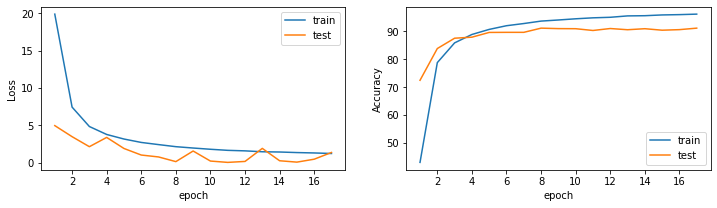

epoch: 17	batch Step: 0	Loss: 1.477	Accuracy: 90.000
epoch: 17	batch Step: 100	Loss: 0.246	Accuracy: 100.000
epoch: 17	batch Step: 200	Loss: 0.037	Accuracy: 100.000
epoch: 17	batch Step: 300	Loss: 0.392	Accuracy: 100.000
epoch: 17	batch Step: 400	Loss: 0.009	Accuracy: 100.000
epoch: 17	batch Step: 500	Loss: 0.046	Accuracy: 100.000
epoch: 17	batch Step: 600	Loss: 4.864	Accuracy: 80.000
epoch: 17	batch Step: 700	Loss: 0.006	Accuracy: 100.000
epoch: 17	batch Step: 800	Loss: 0.374	Accuracy: 100.000
epoch: 17	batch Step: 900	Loss: 0.224	Accuracy: 100.000
epoch: 17	batch Step: 1000	Loss: 4.770	Accuracy: 90.000
epoch: 17	batch Step: 1100	Loss: 0.385	Accuracy: 100.000
epoch: 17	batch Step: 1200	Loss: 4.757	Accuracy: 80.000
epoch: 17	batch Step: 1300	Loss: 1.372	Accuracy: 100.000
epoch: 17	batch Step: 1400	Loss: 3.282	Accuracy: 90.000
epoch: 17	batch Step: 1500	Loss: 0.397	Accuracy: 100.000
epoch: 17	batch Step: 1600	Loss: 1.305	Accuracy: 90.000
epoch: 17	batch Step: 1700	Loss: 0.151	Accuracy: 

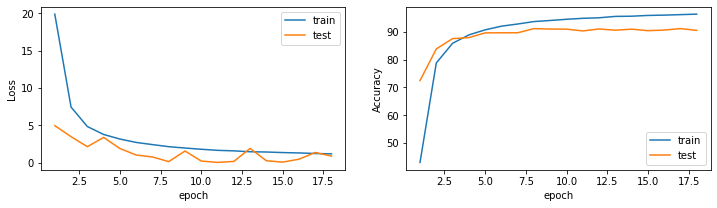

epoch: 18	batch Step: 0	Loss: 1.230	Accuracy: 90.000
epoch: 18	batch Step: 100	Loss: 2.238	Accuracy: 90.000
epoch: 18	batch Step: 200	Loss: 0.161	Accuracy: 100.000
epoch: 18	batch Step: 300	Loss: 0.790	Accuracy: 100.000
epoch: 18	batch Step: 400	Loss: 0.005	Accuracy: 100.000
epoch: 18	batch Step: 500	Loss: 0.321	Accuracy: 100.000
epoch: 18	batch Step: 600	Loss: 0.431	Accuracy: 100.000
epoch: 18	batch Step: 700	Loss: 0.027	Accuracy: 100.000
epoch: 18	batch Step: 800	Loss: 1.627	Accuracy: 100.000
epoch: 18	batch Step: 900	Loss: 1.267	Accuracy: 100.000
epoch: 18	batch Step: 1000	Loss: 1.117	Accuracy: 90.000
epoch: 18	batch Step: 1100	Loss: 0.099	Accuracy: 100.000
epoch: 18	batch Step: 1200	Loss: 2.102	Accuracy: 90.000
epoch: 18	batch Step: 1300	Loss: 0.451	Accuracy: 100.000
epoch: 18	batch Step: 1400	Loss: 1.448	Accuracy: 90.000
epoch: 18	batch Step: 1500	Loss: 0.273	Accuracy: 100.000
epoch: 18	batch Step: 1600	Loss: 0.642	Accuracy: 100.000
epoch: 18	batch Step: 1700	Loss: 1.517	Accuracy:

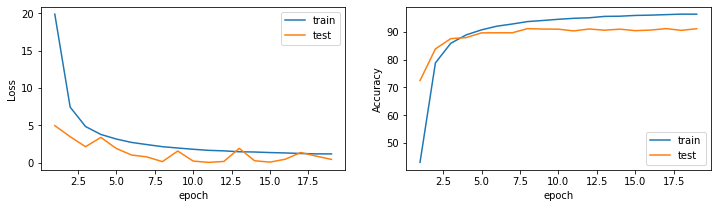

epoch: 19	batch Step: 0	Loss: 1.911	Accuracy: 90.000
epoch: 19	batch Step: 100	Loss: 1.208	Accuracy: 90.000
epoch: 19	batch Step: 200	Loss: 0.166	Accuracy: 100.000
epoch: 19	batch Step: 300	Loss: 0.028	Accuracy: 100.000
epoch: 19	batch Step: 400	Loss: 0.006	Accuracy: 100.000
epoch: 19	batch Step: 500	Loss: 0.118	Accuracy: 100.000
epoch: 19	batch Step: 600	Loss: 4.472	Accuracy: 80.000
epoch: 19	batch Step: 700	Loss: 0.115	Accuracy: 100.000
epoch: 19	batch Step: 800	Loss: 0.072	Accuracy: 100.000
epoch: 19	batch Step: 900	Loss: 0.185	Accuracy: 100.000
epoch: 19	batch Step: 1000	Loss: 2.167	Accuracy: 90.000
epoch: 19	batch Step: 1100	Loss: 2.576	Accuracy: 90.000
epoch: 19	batch Step: 1200	Loss: 5.595	Accuracy: 80.000
epoch: 19	batch Step: 1300	Loss: 2.952	Accuracy: 90.000
epoch: 19	batch Step: 1400	Loss: 0.783	Accuracy: 100.000
epoch: 19	batch Step: 1500	Loss: 3.038	Accuracy: 90.000
epoch: 19	batch Step: 1600	Loss: 0.569	Accuracy: 100.000
epoch: 19	batch Step: 1700	Loss: 0.672	Accuracy: 10

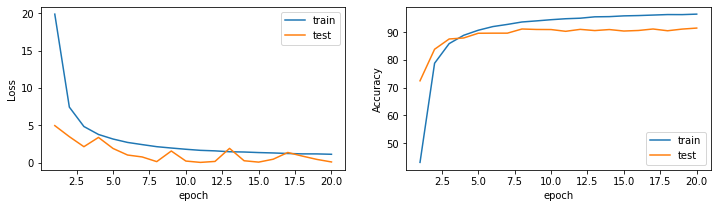

epoch: 20	batch Step: 0	Loss: 4.331	Accuracy: 80.000
epoch: 20	batch Step: 100	Loss: 0.115	Accuracy: 100.000
epoch: 20	batch Step: 200	Loss: 0.091	Accuracy: 100.000
epoch: 20	batch Step: 300	Loss: 0.467	Accuracy: 100.000
epoch: 20	batch Step: 400	Loss: 0.023	Accuracy: 100.000
epoch: 20	batch Step: 500	Loss: 0.017	Accuracy: 100.000
epoch: 20	batch Step: 600	Loss: 4.490	Accuracy: 90.000
epoch: 20	batch Step: 700	Loss: 0.012	Accuracy: 100.000
epoch: 20	batch Step: 800	Loss: 2.291	Accuracy: 90.000
epoch: 20	batch Step: 900	Loss: 0.064	Accuracy: 100.000
epoch: 20	batch Step: 1000	Loss: 2.007	Accuracy: 90.000
epoch: 20	batch Step: 1100	Loss: 0.361	Accuracy: 100.000
epoch: 20	batch Step: 1200	Loss: 1.930	Accuracy: 90.000
epoch: 20	batch Step: 1300	Loss: 1.490	Accuracy: 90.000
epoch: 20	batch Step: 1400	Loss: 2.762	Accuracy: 90.000
epoch: 20	batch Step: 1500	Loss: 0.041	Accuracy: 100.000
epoch: 20	batch Step: 1600	Loss: 0.468	Accuracy: 100.000
epoch: 20	batch Step: 1700	Loss: 3.578	Accuracy: 9

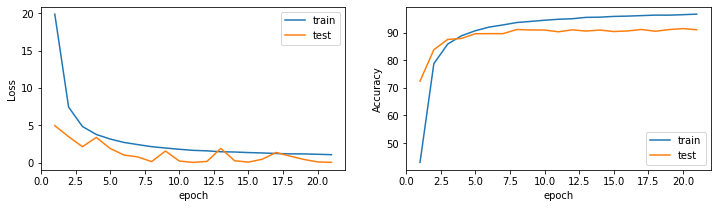

epoch: 21	batch Step: 0	Loss: 1.238	Accuracy: 90.000
epoch: 21	batch Step: 100	Loss: 2.119	Accuracy: 90.000
epoch: 21	batch Step: 200	Loss: 0.006	Accuracy: 100.000
epoch: 21	batch Step: 300	Loss: 0.136	Accuracy: 100.000
epoch: 21	batch Step: 400	Loss: 0.002	Accuracy: 100.000
epoch: 21	batch Step: 500	Loss: 0.084	Accuracy: 100.000
epoch: 21	batch Step: 600	Loss: 2.841	Accuracy: 90.000
epoch: 21	batch Step: 700	Loss: 0.017	Accuracy: 100.000
epoch: 21	batch Step: 800	Loss: 0.058	Accuracy: 100.000
epoch: 21	batch Step: 900	Loss: 0.213	Accuracy: 100.000
epoch: 21	batch Step: 1000	Loss: 0.819	Accuracy: 100.000
epoch: 21	batch Step: 1100	Loss: 1.694	Accuracy: 100.000
epoch: 21	batch Step: 1200	Loss: 3.726	Accuracy: 90.000
epoch: 21	batch Step: 1300	Loss: 1.620	Accuracy: 90.000
epoch: 21	batch Step: 1400	Loss: 0.262	Accuracy: 100.000
epoch: 21	batch Step: 1500	Loss: 0.375	Accuracy: 100.000
epoch: 21	batch Step: 1600	Loss: 1.077	Accuracy: 100.000
epoch: 21	batch Step: 1700	Loss: 0.058	Accuracy:

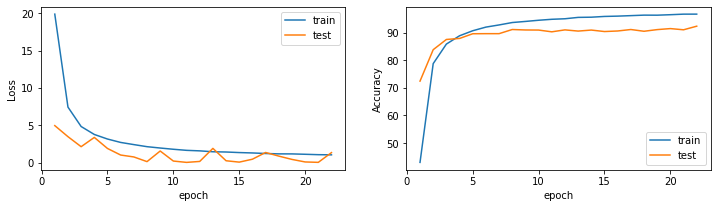

epoch: 22	batch Step: 0	Loss: 2.621	Accuracy: 90.000
epoch: 22	batch Step: 100	Loss: 0.978	Accuracy: 100.000
epoch: 22	batch Step: 200	Loss: 0.074	Accuracy: 100.000
epoch: 22	batch Step: 300	Loss: 0.157	Accuracy: 100.000
epoch: 22	batch Step: 400	Loss: 0.086	Accuracy: 100.000
epoch: 22	batch Step: 500	Loss: 0.034	Accuracy: 100.000
epoch: 22	batch Step: 600	Loss: 2.789	Accuracy: 80.000
epoch: 22	batch Step: 700	Loss: 0.007	Accuracy: 100.000
epoch: 22	batch Step: 800	Loss: 2.409	Accuracy: 90.000
epoch: 22	batch Step: 900	Loss: 0.141	Accuracy: 100.000
epoch: 22	batch Step: 1000	Loss: 0.247	Accuracy: 100.000
epoch: 22	batch Step: 1100	Loss: 0.231	Accuracy: 100.000
epoch: 22	batch Step: 1200	Loss: 0.179	Accuracy: 100.000
epoch: 22	batch Step: 1300	Loss: 0.412	Accuracy: 100.000
epoch: 22	batch Step: 1400	Loss: 1.298	Accuracy: 90.000
epoch: 22	batch Step: 1500	Loss: 0.142	Accuracy: 100.000
epoch: 22	batch Step: 1600	Loss: 0.730	Accuracy: 100.000
epoch: 22	batch Step: 1700	Loss: 0.745	Accuracy

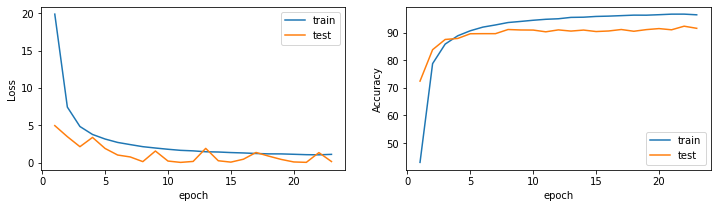

epoch: 23	batch Step: 0	Loss: 0.301	Accuracy: 100.000
epoch: 23	batch Step: 100	Loss: 0.429	Accuracy: 100.000
epoch: 23	batch Step: 200	Loss: 0.027	Accuracy: 100.000
epoch: 23	batch Step: 300	Loss: 0.955	Accuracy: 100.000
epoch: 23	batch Step: 400	Loss: 0.015	Accuracy: 100.000
epoch: 23	batch Step: 500	Loss: 0.094	Accuracy: 100.000
epoch: 23	batch Step: 600	Loss: 2.243	Accuracy: 90.000
epoch: 23	batch Step: 700	Loss: 0.002	Accuracy: 100.000
epoch: 23	batch Step: 800	Loss: 0.489	Accuracy: 100.000
epoch: 23	batch Step: 900	Loss: 0.445	Accuracy: 100.000
epoch: 23	batch Step: 1000	Loss: 1.624	Accuracy: 90.000
epoch: 23	batch Step: 1100	Loss: 0.257	Accuracy: 100.000
epoch: 23	batch Step: 1200	Loss: 2.479	Accuracy: 90.000
epoch: 23	batch Step: 1300	Loss: 0.157	Accuracy: 100.000
epoch: 23	batch Step: 1400	Loss: 1.355	Accuracy: 90.000
epoch: 23	batch Step: 1500	Loss: 0.014	Accuracy: 100.000
epoch: 23	batch Step: 1600	Loss: 1.430	Accuracy: 100.000
epoch: 23	batch Step: 1700	Loss: 0.395	Accuracy

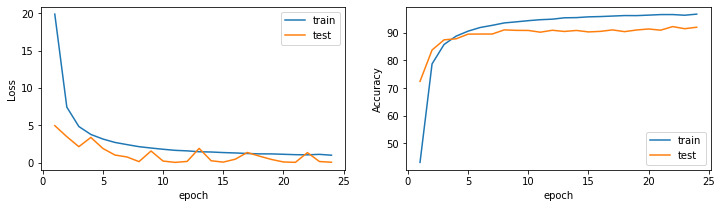

epoch: 24	batch Step: 0	Loss: 0.245	Accuracy: 100.000
epoch: 24	batch Step: 100	Loss: 4.462	Accuracy: 90.000
epoch: 24	batch Step: 200	Loss: 0.461	Accuracy: 100.000
epoch: 24	batch Step: 300	Loss: 0.031	Accuracy: 100.000
epoch: 24	batch Step: 400	Loss: 0.027	Accuracy: 100.000
epoch: 24	batch Step: 500	Loss: 0.092	Accuracy: 100.000
epoch: 24	batch Step: 600	Loss: 1.102	Accuracy: 90.000
epoch: 24	batch Step: 700	Loss: 0.024	Accuracy: 100.000
epoch: 24	batch Step: 800	Loss: 0.032	Accuracy: 100.000
epoch: 24	batch Step: 900	Loss: 0.365	Accuracy: 100.000
epoch: 24	batch Step: 1000	Loss: 4.238	Accuracy: 90.000
epoch: 24	batch Step: 1100	Loss: 1.162	Accuracy: 100.000
epoch: 24	batch Step: 1200	Loss: 0.689	Accuracy: 100.000
epoch: 24	batch Step: 1300	Loss: 0.784	Accuracy: 100.000
epoch: 24	batch Step: 1400	Loss: 2.424	Accuracy: 90.000
epoch: 24	batch Step: 1500	Loss: 0.403	Accuracy: 100.000
epoch: 24	batch Step: 1600	Loss: 0.332	Accuracy: 100.000
epoch: 24	batch Step: 1700	Loss: 3.221	Accuracy

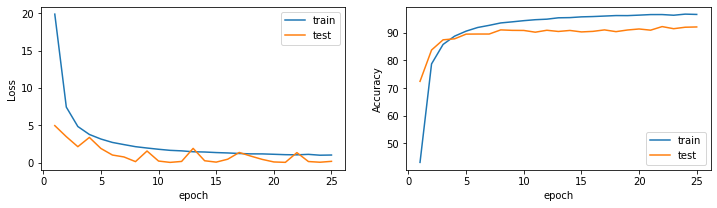

train_epoch_loss: [19.891650935676363, 7.430794474544625, 4.828976741912602, 3.763776081084722, 3.1520690154844755, 2.695235947746335, 2.4053389854200993, 2.1266615273905227, 1.9462870865925517, 1.7795353380745467, 1.6361534035926322, 1.565995874995672, 1.4458791799338306, 1.4124618192483334, 1.337619984112502, 1.2856641840546488, 1.2122537699603628, 1.162709505515482, 1.1578855124432637, 1.1077787374763661, 1.0540479379076444, 1.0335712953183382, 1.0974867533039894, 0.9830252271484857, 1.0073226420893022]
test_epoch_loss: [4.9506983160972595, 3.467623591423034, 2.125484049320221, 3.3671897649765006, 1.886395663022995, 1.0066726058721542, 0.7500864565372467, 0.12376617640256882, 1.5447229146957397, 0.19981624558568, 0.021095857955515385, 0.14875218272209167, 1.8973739445209508, 0.24004807695746422, 0.05618190858513117, 0.4472549632191657, 1.3486629724502563, 0.8635792881250381, 0.4194255918264389, 0.0793267972767353, 0.0256832828745246, 1.3317228853702545, 0.13533922843635082, 0.042236

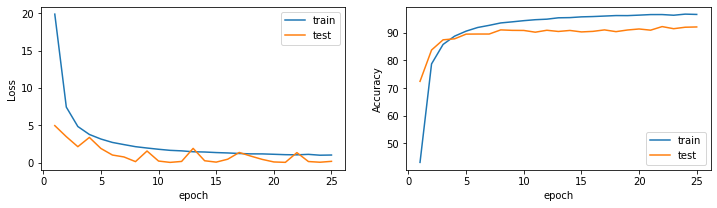

In [23]:
# 통일성 있게 코드 짜자.
train_epoch_loss = []
train_epoch_acc = []
test_epoch_loss = []
test_epoch_acc = []

batch_size = 10

for epoch in range(epochs):

    ''' Train '''
    model.train()
    train_batch_loss = []
    train_batch_acc = []
   
    
    train_batch_num = int(len(X_train)/batch_size)
    # print("train_batch_num: ", train_batch_num)
    for batch_idx in range(train_batch_num):
        
        mini_batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
        mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
        mini_batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
        x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

        optimizer.zero_grad()
        output = model(x) # output.shape = (50, 30)
        target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
        target = torch.argmax(target, dim=1) # -> (50) 
        # print(output.shape)
        # print(target.shape)

        loss = F.nll_loss(output, target).to(device)

        # reg_lambda=0.01
        # l2_reg = 0
        # # for regualrization
        # for name, param in model.named_parameters():
        #     if "weight" in name:
        #         l2_reg = l2_reg + param.norm(1)
        # loss = loss + l2_reg * reg_lambda  #  Parameters 가 아닌 Tensor 를 더하면 안됩니다.
        # # 그러면, 상수값 아님?
        
        loss.backward()    # calc gradients
        train_batch_loss.append(loss.item()/batch_size*100) # from tensor -> get value loss.item() or loss.data
        optimizer.step()   # update gradients
        prediction = output.argmax(dim=1, keepdims=True)
        accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
        train_batch_acc.append(accuracy)
        if batch_idx % print_interval == 0:
            print('epoch: {}\tbatch Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(
                    epoch, batch_idx, train_batch_loss[batch_idx], train_batch_acc[batch_idx]))

    train_epoch_loss.append(np.sum(train_batch_loss)/train_batch_num)
    train_epoch_acc.append(np.sum(train_batch_acc)/train_batch_num)


    ''' Test '''
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    
    test_batch_num = int(len(X_test)/batch_size)
    # print("train_batch_num: ", test_batch_num)
    with torch.no_grad():
        for batch_idx in range(test_batch_num):         
            mini_batch_x = X_test[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
            mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
            mini_batch_y = Y_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

            optimizer.zero_grad()
            output = model(x) # output.shape = (50, 30)
            target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
            target = torch.argmax(target, dim=1) # -> (50) 

            x, target = Variable(x).to(device), Variable(target).to(device)
            output = model(x)
            test_batch_loss.append(loss.item()/batch_size*100)
            prediction = output.argmax(dim=1, keepdims=True)
            accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
            test_batch_acc.append(accuracy)

    test_epoch_loss.append(np.sum(test_batch_loss)/test_batch_num)
    test_epoch_acc.append(np.sum(test_batch_acc)/test_batch_num)

    ############### 중간 plot & 모델 저장
    x = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(x, train_epoch_loss, label='train')
    plt.plot(x, test_epoch_loss, label='test')
    ax1.legend()
    ax1.set(ylabel="Loss", xlabel='epoch')

    ax2 = fig.add_subplot(1, 2, 2)
    plt.plot(x, train_epoch_acc, label='train')
    plt.plot(x, test_epoch_acc, label='test')
    ax2.legend()
    ax2.set(ylabel="Accuracy", xlabel='epoch')

    plt.show()

    # ''' inference를 위한 모델 저장  '''
    model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
    model_name = "./CNN"
    option = 2

    if option == 0:
        model_path = model_name + '_all.pt'
        torch.save(model, model_path)

    elif option == 1:
        model_path = model_name + '_state_dict.pt'
        torch.save(model.state_dict, model_path)

    elif option == 2:
        model_path = model_name + '_ckp.tar'
        torch.save({
                'last_epoch': epochs -1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, model_path)
    ################ 중간 plot & 모델 저장


''' save results to numpy '''
train_test_result = (train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc)
np.save("result.npy", train_test_result)

print("==================================")
print("train_epoch_loss:", train_epoch_loss)
print("test_epoch_loss:", test_epoch_loss)
print("train_epoch_acc", train_epoch_acc)
print("test_epoch_acc", test_epoch_acc)
print("==================================")
x = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(x, train_epoch_loss, label='train')
plt.plot(x, test_epoch_loss, label='test')
ax1.legend()
ax1.set(ylabel="Loss", xlabel='epoch')

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(x, train_epoch_acc, label='train')
plt.plot(x, test_epoch_acc, label='test')
ax2.legend()
ax2.set(ylabel="Accuracy", xlabel='epoch')

plt.show()

# ''' inference를 위한 모델 저장  '''
model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./CNN"
option = 2

if option == 0:
    model_path = model_name + '_all.pt'
    torch.save(model, model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    torch.save(model.state_dict, model_path)

elif option == 2:
    model_path = model_name + '_ckp.tar'
    torch.save({
            'last_epoch': epochs -1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_path)
    

In [49]:
# ## 위에 곡선 좋았어

# ''' 모델 불러오기 '''

# model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
# model_name = "./CNN"
# option = 2

# if option == 0:
#     # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
#     model_path = model_name + '_all.pt'
#     model = torch.load(model_path)

# elif option == 1:
#     model_path = model_name + '_state_dict.pt'
#     model = CNN_Net()
#     model.load_state_dict(torch.load(model_path))

# elif option == 2:
#     # model, optimizer 초기화
#     #model = CNN_Net().to(device)
#     #optimizer = optim.Adam(model.parameters(), lr=lr)
#     #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#     model_path = model_name + '_ckp.tar'
#     checkpoint = torch.load(model_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     last_epoch = checkpoint['last_epoch']
#     loss = checkpoint['loss']

# for epoch in range(last_epoch+1, 50):

#     ''' Train '''
#     model.train()
#     train_batch_loss = []
#     train_batch_acc = []
   
    
#     train_batch_num = int(len(X_train)/batch_size)
#     # print("train_batch_num: ", train_batch_num)
#     for batch_idx in range(train_batch_num):
        
#         mini_batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
#         mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
#         mini_batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
#         x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

#         optimizer.zero_grad()
#         output = model(x) # output.shape = (50, 30)
#         target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
#         target = torch.argmax(target, dim=1) # -> (50) 
#         # print(output.shape)
#         # print(target.shape)

#         loss = F.nll_loss(output, target).to(device)

#         # loss = nn.CrossEntropyLoss(output, target).to(device) 
        
#         loss.backward()    # calc gradients
#         train_batch_loss.append(loss.item()/batch_size*100) # from tensor -> get value loss.item() or loss.data
#         optimizer.step()   # update gradients
#         prediction = output.argmax(dim=1, keepdims=True)
#         accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
#         train_batch_acc.append(accuracy)
#         if batch_idx % print_interval == 0:
#             print('epoch: {}\tbatch Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(
#                     epoch, batch_idx, train_batch_loss[batch_idx], train_batch_acc[batch_idx]))

#     train_epoch_loss.append(np.sum(train_batch_loss)/train_batch_num)
#     train_epoch_acc.append(np.sum(train_batch_acc)/train_batch_num)


#     ''' Test '''
#     model.eval()
#     test_batch_loss = []
#     test_batch_acc = []
    
#     test_batch_num = int(len(X_test)/batch_size)
#     # print("train_batch_num: ", test_batch_num)
#     with torch.no_grad():
#         for batch_idx in range(test_batch_num):         
#             mini_batch_x = X_test[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
#             mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
#             mini_batch_y = Y_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
#             x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

#             optimizer.zero_grad()
#             output = model(x) # output.shape = (50, 30)
#             target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
#             target = torch.argmax(target, dim=1) # -> (50) 

#             x, target = Variable(x).to(device), Variable(target).to(device)
#             output = model(x)
#             test_batch_loss.append(loss.item()/batch_size*100)
#             prediction = output.argmax(dim=1, keepdims=True)
#             accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
#             test_batch_acc.append(accuracy)

#     test_epoch_loss.append(np.sum(test_batch_loss)/test_batch_num)
#     test_epoch_acc.append(np.sum(test_batch_acc)/test_batch_num)

#     ############### 중간 plot & 모델 저장
#     x = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

#     fig = plt.figure(figsize=(12, 3))
#     ax1 = fig.add_subplot(1, 2, 1)
#     plt.plot(x, train_epoch_loss, label='train')
#     plt.plot(x, test_epoch_loss, label='test')
#     ax1.legend()
#     ax1.set(ylabel="Loss", xlabel='epoch')

#     ax2 = fig.add_subplot(1, 2, 2)
#     plt.plot(x, train_epoch_acc, label='train')
#     plt.plot(x, test_epoch_acc, label='test')
#     ax2.legend()
#     ax2.set(ylabel="Accuracy", xlabel='epoch')

#     plt.show()

#     # ''' inference를 위한 모델 저장  '''
#     model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
#     model_name = "./CNN"
#     option = 2

#     if option == 0:
#         model_path = model_name + '_all.pt'
#         torch.save(model, model_path)

#     elif option == 1:
#         model_path = model_name + '_state_dict.pt'
#         torch.save(model.state_dict, model_path)

#     elif option == 2:
#         model_path = model_name + '_ckp.tar'
#         torch.save({
#                 'last_epoch': epochs -1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 }, model_path)
#     ################ 중간 plot & 모델 저장


# ''' save results to numpy '''
# train_test_result = (train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc)
# np.save("result.npy", train_test_result)

# print("==================================")
# print("train_epoch_loss:", train_epoch_loss)
# print("test_epoch_loss:", test_epoch_loss)
# print("train_epoch_acc", train_epoch_acc)
# print("test_epoch_acc", test_epoch_acc)
# print("==================================")
# x = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

# fig = plt.figure(figsize=(12, 3))
# ax1 = fig.add_subplot(1, 2, 1)
# plt.plot(x, train_epoch_loss, label='train')
# plt.plot(x, test_epoch_loss, label='test')
# ax1.legend()
# ax1.set(ylabel="Loss", xlabel='epoch')

# ax2 = fig.add_subplot(1, 2, 2)
# plt.plot(x, train_epoch_acc, label='train')
# plt.plot(x, test_epoch_acc, label='test')
# ax2.legend()
# ax2.set(ylabel="Accuracy", xlabel='epoch')

# plt.show()

# # ''' inference를 위한 모델 저장  '''
# model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
# model_name = "./CNN"
# option = 2

# if option == 0:
#     model_path = model_name + '_all.pt'
#     torch.save(model, model_path)

# elif option == 1:
#     model_path = model_name + '_state_dict.pt'
#     torch.save(model.state_dict, model_path)

# elif option == 2:
#     model_path = model_name + '_ckp.tar'
#     torch.save({
#             'last_epoch': epochs -1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, model_path)
    

FileNotFoundError: ignored

## audio test
https://musicinformationretrieval.com/ipython_audio.html

In [54]:
import IPython.display as ipd
import librosa

def match_1s(data):
    # 30sec 길이 통일
    num = 22050
    # print(data.shape, end=' ->')
    if len(data) < 22050:
        num = 22050 - len(data)
        temp = np.zeros(num) #* 1e-05
        data = np.append(data, temp)
    elif len(data) > 22050:
        data = data[:22050]

    #print(data.shape, end=' ')

    # (22050,) to column vector : (2250, 1)
    # data = data.reshape(len(data), 1)

    return data


def feature_mfcc(RECORD_FILE_NAME):

    # 조정할 수 있는 건 다 적어보자.

    # sr = 22050 = bitrate/2 -> Q. bitrate 와 어떤 관계?
    # Generate mfccs from a time series
    # t초당 sig.shape = (t*sr,)
    sig, sr = librosa.load(RECORD_FILE_NAME)  # , sr=sr
    # 만약, sr=16000, mfcc.shape = (n_mfcc,1251)
    #       sr=(default)22050, mfcc.shape = (n_mfcc, 1723)


    hop_length = 0
    if len(sig) == 22050:  # 128 -> mfcc Tx 301, 223 -> mfcc Tx 173
        hop_length = 128
    elif len(sig) == 38433:
        hop_length = 223  # Tx 173 으로 통일
    elif len(sig) < 22050:
        # print("smaller than", end=' ')
        sig = match_1s(sig)
        hop_length = 128

    else:
        # print(len(sig))
        sig = match_1s(sig)
        print("1s over")
        hop_length = 128

    n_mfcc = 24
    # n_mels = 20
    n_fft = 101
    fmin = 0
    fmax = None
    # sr = 16000


    mfcc = librosa.feature.mfcc(y=sig, sr=sr, hop_length=hop_length, fmin=fmin, fmax = fmax,
                                  n_fft= n_fft, n_mfcc=n_mfcc)
    # print("here", mfcc.shape)

    return mfcc

In [62]:
audio_path = './dev_word/stop.wav' # 'stop_not_mine.wav' # 'extraction.wav'
ipd.Audio(audio_path)

In [63]:
mfcc = feature_mfcc(audio_path)
print(mfcc.shape)

1s over
(24, 173)


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [64]:
''' 모델 불러오기 '''

model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./CNN"
option = 2

if option == 0:
    # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
    model_path = model_name + '_all.pt'
    model = torch.load(model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    model = CNN_Net().to(device)
    model.load_state_dict(torch.load(model_path))

elif option == 2:
    # model, optimizer 초기화
    #model = CNN_Net().to(device)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    model_path = model_name + '_ckp.tar'
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['last_epoch']
    loss = checkpoint['loss']


''' Audio Test '''

classes = ['bed', 'bird', 'cat', 'dog', 'down', 
           'eight', 'five', 'four', 'go', 'happy', 
           'house', 'left', 'marvin', 'nine', 'no', 
           'off', 'on', 'one', 'right', 'seven', 
           'sheila', 'six', 'stop', 'three', 'tree', 
           'two', 'up', 'wow', 'yes', 'zero']

model.eval()

with torch.no_grad():
    # mfcc.shape = (24, 173) -> (batch_szie=1, channel=1, 173, 24)
    mfcc = mfcc.transpose()
    print(mfcc.shape) ##
    x = np.expand_dims(mfcc, axis=(0, 1))
    x = Variable(torch.Tensor(x)).to(device)
    #print(x.shape) ##
    output = model(x) # output.shape = (1, 30)
    print(output.shape) ##
    output = torch.exp(output).float()
    for i in range(num_class):
        print(classes[i], ":", output[0][i].cpu())
    prediction = output.argmax(dim=1, keepdims=True)
    print("prediction : ", classes[prediction])


model.eval()
model.cuda()
test_batch_num = int(len(X_test)/batch_size)
# print("train_batch_num: ", test_batch_num)
with torch.no_grad():
    for batch_idx in range(test_batch_num):         
        mini_batch_x = X_test[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
        mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
        mini_batch_y = Y_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
        x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

    output = model(x) # output.shape = (1, 30)
    prediction = output.argmax(dim=1, keepdims=True)
    for b in range(batch_size):
        print("target :", classes[target[b].argmax(dim=1).item()], " || prediction :", classes[prediction[b]])


(173, 24)
torch.Size([1, 30])
bed : tensor(2.7969e-18)
bird : tensor(1.7564e-14)
cat : tensor(1.6413e-16)
dog : tensor(9.5888e-09)
down : tensor(4.0643e-13)
eight : tensor(6.2174e-18)
five : tensor(6.7394e-11)
four : tensor(5.2684e-13)
go : tensor(1.0821e-16)
happy : tensor(5.2093e-16)
house : tensor(5.1313e-17)
left : tensor(1.6460e-17)
marvin : tensor(1.7273e-16)
nine : tensor(2.2285e-15)
no : tensor(2.3907e-17)
off : tensor(2.6432e-11)
on : tensor(1.9072e-17)
one : tensor(2.4094e-17)
right : tensor(1.9036e-19)
seven : tensor(3.1919e-12)
sheila : tensor(1.1295e-16)
six : tensor(1.9877e-15)
stop : tensor(1.0000)
three : tensor(2.4280e-12)
tree : tensor(6.8226e-24)
two : tensor(2.9637e-18)
up : tensor(2.4011e-07)
wow : tensor(1.8855e-13)
yes : tensor(1.6833e-17)
zero : tensor(1.8852e-16)
prediction :  stop
target : five  || prediction : five
target : four  || prediction : four
target : four  || prediction : four
target : bird  || prediction : bird
target : two  || prediction : two
targ